In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ctr-data/ctr.csv


In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

data = pd.read_csv("../input/ctr-data/ctr.csv")
print(data.head())

         Date  Clicks  Impressions
0  2022-10-19    2851        58598
1  2022-10-20    2707        57628
2  2022-10-21    2246        50135
3  2022-10-22    1686        40608
4  2022-10-23    1808        41999


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         365 non-null    object
 1   Clicks       365 non-null    int64 
 2   Impressions  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [4]:
print(data['Date'].head())
print(data['Date'].tail())

0    2022-10-19
1    2022-10-20
2    2022-10-21
3    2022-10-22
4    2022-10-23
Name: Date, dtype: object
360    2023-10-14
361    2023-10-15
362    2023-10-16
363    2023-10-17
364    2023-10-18
Name: Date, dtype: object


In [5]:
data.rename(columns=lambda x: x.strip(), inplace=True)
print(data.columns) 


Index(['Date', 'Clicks', 'Impressions'], dtype='object')


In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='coerce')


In [7]:
# Visualize Clicks and Impressions
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Clicks'], mode='lines', name='Clicks'))
fig.add_trace(go.Scatter(x=data.index, y=data['Impressions'], mode='lines', name='Impressions'))
fig.update_layout(title='Clicks and Impressions Over Time')
fig.show()

<Axes: title={'center': 'Monthly Aggregated Clicks and Impressions'}, xlabel='Month'>

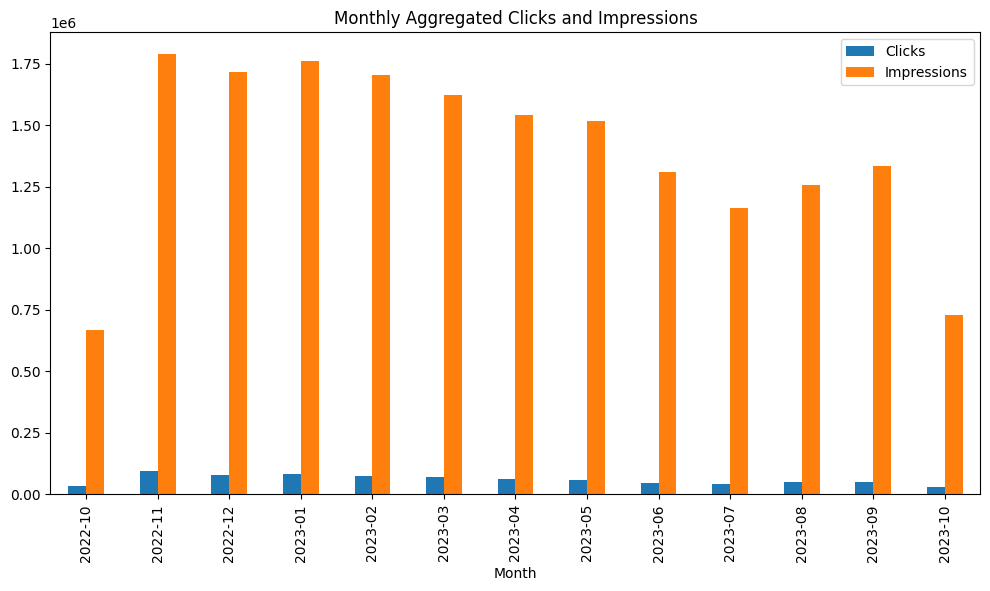

In [8]:
# Ensure 'Date' is a DatetimeIndex
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.set_index('Date', inplace=True)

# Generate monthly period column
data['Month'] = data.index.to_period('M')

# Aggregate by month and plot
monthly_data = data.groupby('Month').sum()
monthly_data[['Clicks', 'Impressions']].plot(kind='bar', figsize=(12, 6), title='Monthly Aggregated Clicks and Impressions')


<Axes: title={'center': 'Click-Through Rate (CTR) Over Time'}, xlabel='Date'>

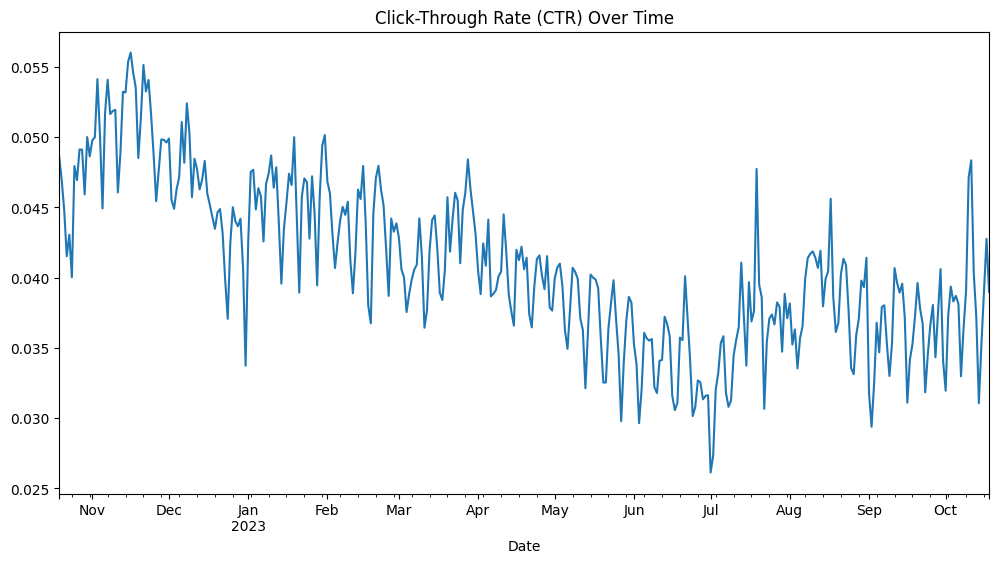

In [9]:
data['CTR'] = data['Clicks'] / data['Impressions']
data['CTR'].plot(figsize=(12, 6), title='Click-Through Rate (CTR) Over Time')


<Axes: title={'center': '7-Day Rolling Average of Clicks and Impressions'}, xlabel='Date'>

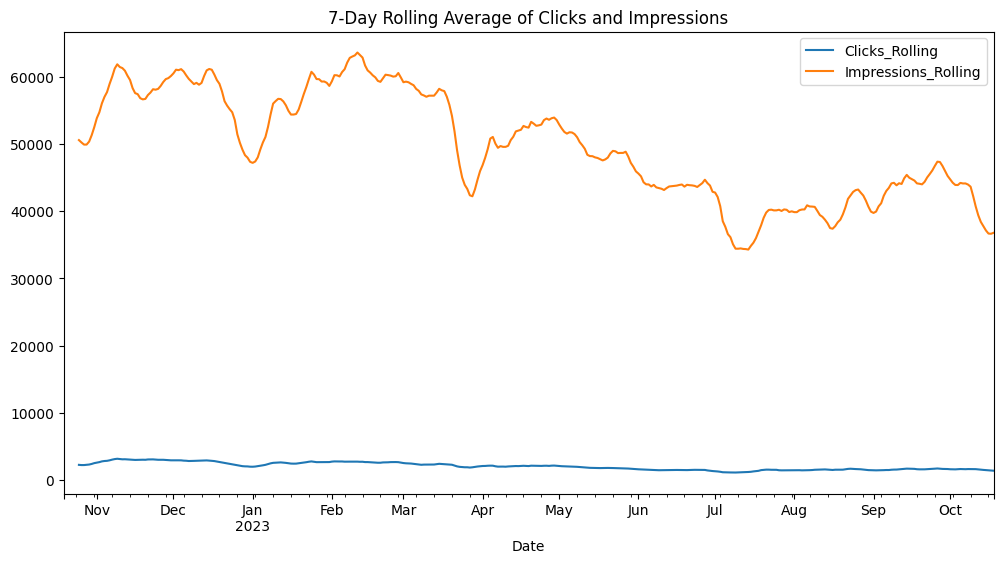

In [10]:
data['Clicks_Rolling'] = data['Clicks'].rolling(window=7).mean()
data['Impressions_Rolling'] = data['Impressions'].rolling(window=7).mean()
data[['Clicks_Rolling', 'Impressions_Rolling']].plot(figsize=(12, 6), title='7-Day Rolling Average of Clicks and Impressions')


In [11]:
correlation = data[['Clicks', 'Impressions']].corr()
print("Correlation matrix:\n", correlation)


Correlation matrix:
                Clicks  Impressions
Clicks       1.000000     0.945812
Impressions  0.945812     1.000000


In [12]:
# Create a scatter plot to visualize the relationship between Clicks and Impressions
fig = px.scatter(data, x='Clicks', y='Impressions', title='Relationship Between Clicks and Impressions',
                 labels={'Clicks': 'Clicks', 'Impressions': 'Impressions'})

# Customize the layout
fig.update_layout(xaxis_title='Clicks', yaxis_title='Impressions')

# Show the plot
fig.show()

In [13]:
# Add Day of the Week
data['DayOfWeek'] = data.index.dayofweek

# Add Week of the Month (Approximation)
data['WeekOfMonth'] = (data.index.day - 1) // 7 + 1

# EDA based on DayOfWeek
day_of_week_ctr = data.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_of_week_ctr['DayOfWeek'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot Average CTR by Day of the Week
import plotly.express as px

fig = px.bar(day_of_week_ctr, x='DayOfWeek', y='CTR', title='Average CTR by Day of the Week')
fig.show()


In [14]:
# Create a new column 'DayCategory' to categorize weekdays and weekends
data['DayCategory'] = data['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average CTR for weekdays and weekends
ctr_by_day_category = data.groupby('DayCategory')['CTR'].mean().reset_index()

# Create a bar plot to compare CTR on weekdays vs. weekends
fig = px.bar(ctr_by_day_category, x='DayCategory', y='CTR', title='Comparison of CTR on Weekdays vs. Weekends',
             labels={'CTR': 'Average CTR'})

# Customize the layout
fig.update_layout(yaxis_title='Average CTR')

# Show the plot
fig.show()

In [15]:
# Group the data by 'DayCategory' and calculate the sum of Clicks and Impressions for each category
grouped_data = data.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

# Create a grouped bar chart to visualize Clicks and Impressions on weekdays vs. weekends
fig = px.bar(grouped_data, x='DayCategory', y=['Clicks', 'Impressions'],
             title='Impressions and Clicks on Weekdays vs. Weekends',
             labels={'value': 'Count', 'variable': 'Metric'},
             color_discrete_sequence=['blue', 'green'])

# Customize the layout
fig.update_layout(yaxis_title='Count')
fig.update_xaxes(title_text='Day Category')

# Show the plot
fig.show()

we can use Time Series forecasting techniques to forecast CTR. As CTR is seasonal, let’s calculate the p, d, and q values for the SARIMA model:

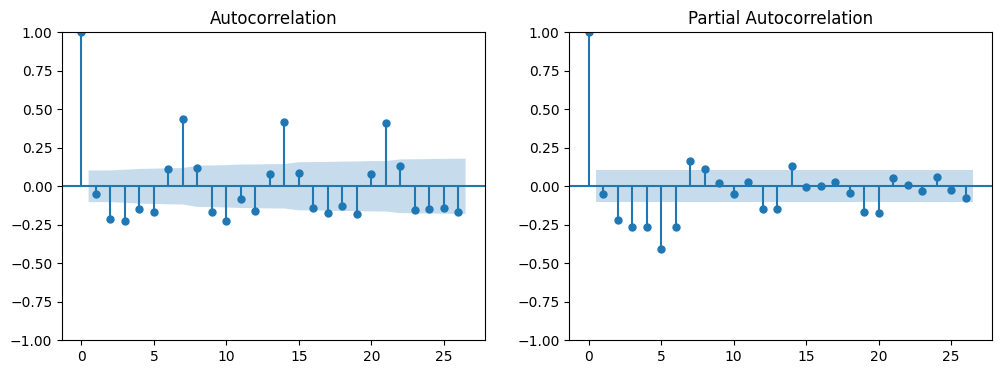

In [16]:
data.reset_index(inplace=True)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# resetting index
time_series = data.set_index('Date')['CTR']

# Differencing
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, s = 1, 1, 1, 12

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1544.201
Date:                            Thu, 16 Jan 2025   AIC                          -3078.401
Time:                                    13:28:24   BIC                          -3059.083
Sample:                                10-19-2022   HQIC                         -3070.714
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4411      0.073      6.074      0.000       0.299       0.583
ma.L1         -0.8724      0.040   

In [18]:
# Predict future values
future_steps = 200
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)

2023-10-19    0.038509
2023-10-20    0.039217
2023-10-21    0.038536
2023-10-22    0.038636
2023-10-23    0.039000
                ...   
2024-05-01    0.040930
2024-05-02    0.041400
2024-05-03    0.039537
2024-05-04    0.038729
2024-05-05    0.038564
Freq: D, Name: predicted_mean, Length: 200, dtype: float64


In [19]:
# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='CTR Forecasting',
                  xaxis_title='Time Period',
                  yaxis_title='Impressions',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()